# epymorph live demo

This is a demo of epymorph usage, showing off how we can use epymorph to rapidly explore different modeling scenarios.

In [1]:
from datetime import date

import matplotlib.pyplot as plt
import numpy as np

from epymorph.context import Compartments, SimContext
from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.geo import filter_geo
from epymorph.initializer import single_location, top_locations
from epymorph.simulation import Output, Simulation, with_fancy_messaging
from epymorph.util import stridesum


def event_y_axis(out: Output, event_idx: int) -> np.ndarray:
    """Utility function for graphing incidence time-series."""
    taus_per_day = len(out.ctx.clock.taus)
    y_values = np.zeros((out.ctx.nodes, out.ctx.clock.num_days))
    for pop_idx in range(out.ctx.nodes):
        events_by_tau = out.incidence[:, pop_idx, event_idx]
        y_values[pop_idx] = stridesum(events_by_tau, taus_per_day)
    return y_values.T


## Example 1: run SIRS with commuter movement in 6 US states

Running simulation (BasicEngine):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.303s


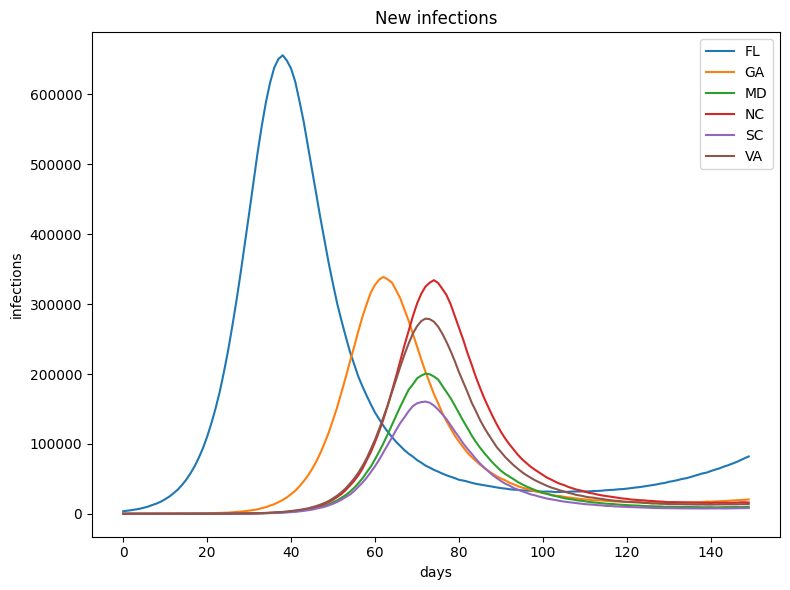

In [2]:
ipm = ipm_library['sirs']()
mm = mm_library['pei']()
geo = geo_library['pei']()

sim = with_fancy_messaging(Simulation(geo, ipm, mm))

param = {
    # IPM params
    'beta': 0.35,
    'gamma': 1/6,
    'xi': 1/90,

    # MM params
    'theta': 0.1,
    'move_control': 0.9,
}


def init(ctx: SimContext) -> Compartments:
    return single_location(ctx, location=0, seed_size=10_000)


out = sim.run(
    param=param,
    start_date=date(2015, 1, 1),
    duration_days=150,
    initializer=init
)

fig, ax = plt.subplots(figsize=(8, 6))
x_axis = np.arange(out.ctx.clock.num_days)
y_axis = event_y_axis(out, 0)
ax.plot(x_axis, y_axis, label=out.ctx.labels)
ax.set(title='New infections', ylabel='infections', xlabel='days')
ax.legend()
fig.tight_layout()
plt.show()


## Example 2: swap IPM to study hospitalization

Running simulation (BasicEngine):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.370s


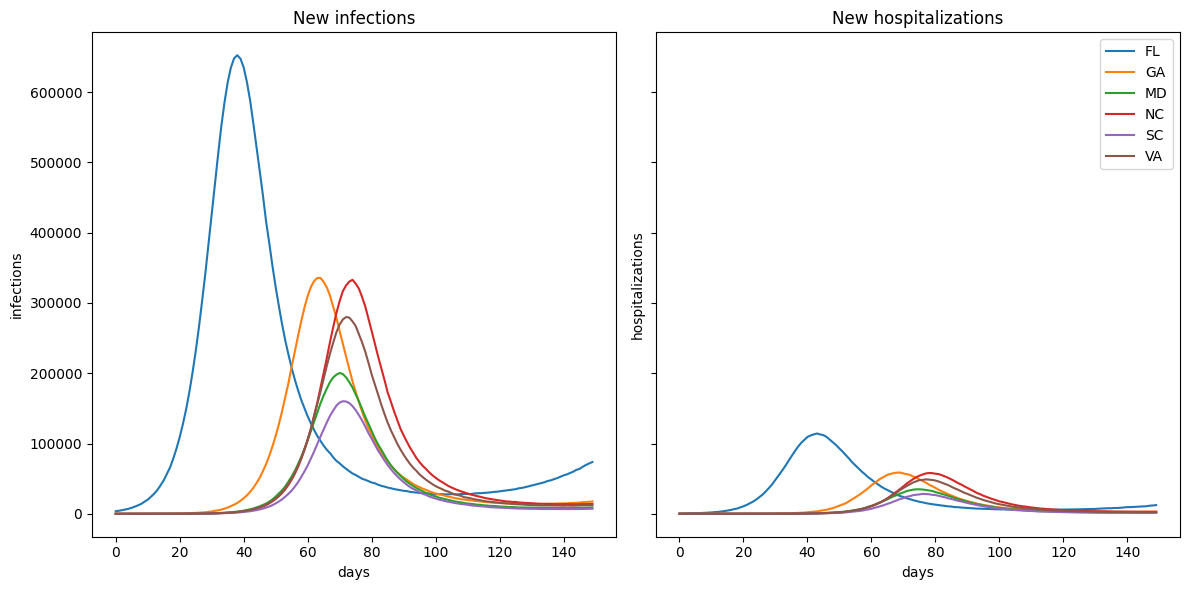

In [3]:
ipm = ipm_library['sirh']()
mm = mm_library['pei']()  # same MM
geo = geo_library['pei']()  # same GEO

sim = with_fancy_messaging(Simulation(geo, ipm, mm))

param = {
    # IPM params
    'beta': 0.35,
    'gamma': 1/6,
    'xi': 1/90,
    'hospitalization_rate': 0.2,
    'hospitalization_duration': 14.0,

    # MM params
    'theta': 0.1,
    'move_control': 0.9,
}

def init(ctx: SimContext) -> Compartments: # same initializer
    return single_location(ctx, location=0, seed_size=10_000)

out = sim.run(
    param=param,
    start_date=date(2015, 1, 1),
    duration_days=150,
    initializer=init
)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
x_axis = np.arange(out.ctx.clock.num_days)
ax1.plot(x_axis, event_y_axis(out, 0), label=out.ctx.labels)
ax2.plot(x_axis, event_y_axis(out, 1), label=out.ctx.labels)

ax1.set(title='New infections', ylabel='infections', xlabel='days')
ax2.set(title='New hospitalizations', ylabel='hospitalizations', xlabel='days')
ax2.legend()
fig.tight_layout()
plt.show()


## Example 3: swap GEO to study county transmission

Running simulation (BasicEngine):
• 2015-01-01 to 2015-05-31 (150 days)
• 48 geo nodes
|####################| 100% 
Runtime: 3.149s


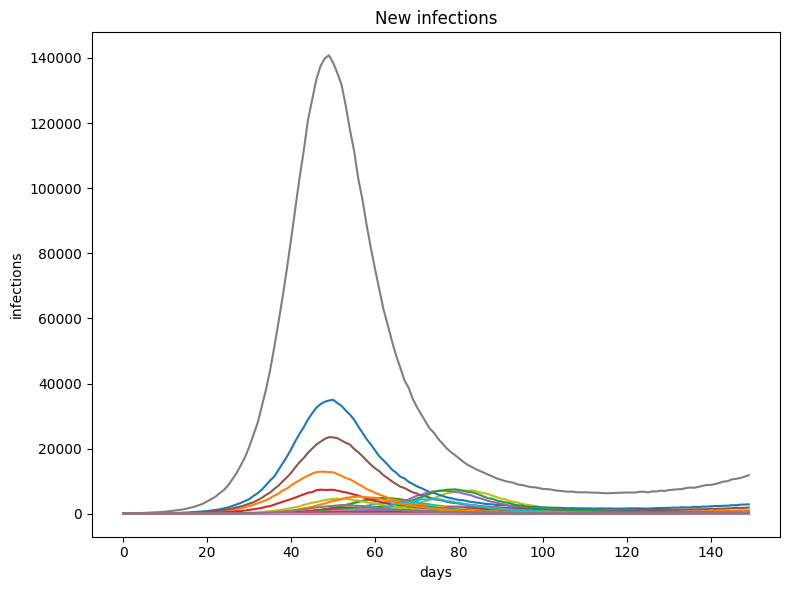

In [4]:
us_counties = geo_library['us_counties_2015']()

# Let's use just Arizona and New Mexico counties
selection = np.where([
    geoid.startswith('04') or geoid.startswith('35')
    for geoid in us_counties.data['geoid']
])[0]

geo = filter_geo(us_counties, selection)

ipm = ipm_library['sirh']()  # same IPM
mm = mm_library['pei']()  # same MM

sim = with_fancy_messaging(Simulation(geo, ipm, mm))


def init(ctx: SimContext):
    return top_locations(ctx, attribute='population', num_locations=5, seed_size=500)


out = sim.run(
    param={  # same params
        # IPM params
        'beta': 0.35,
        'gamma': 1/6,
        'xi': 1/90,
        'hospitalization_rate': 0.05,
        'hospitalization_duration': 14.0,

        # MM params
        'theta': 0.1,
        'move_control': 0.9,
    },
    start_date=date(2015, 1, 1),
    duration_days=150,
    initializer=init
)

fig, ax = plt.subplots(figsize=(8, 6))
x_axis = np.arange(out.ctx.clock.num_days)
ax.plot(x_axis, event_y_axis(out, 0))
ax.set(title='New infections', ylabel='infections', xlabel='days')
fig.tight_layout()
plt.show()


## Bonus Example: what if beta changes by time and location?

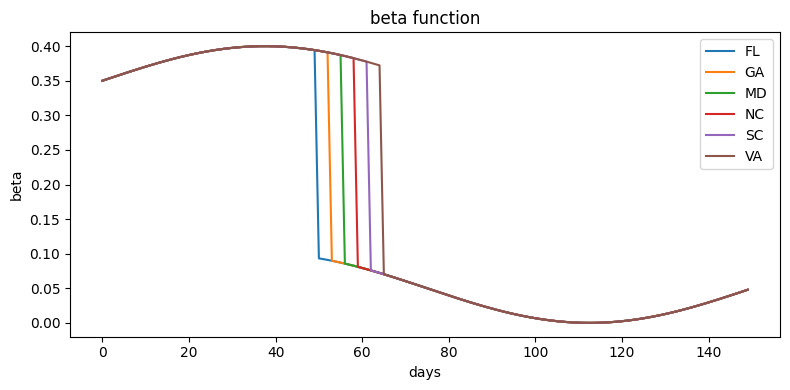

In [5]:
ipm = ipm_library['sirs']()
mm = mm_library['pei']()
geo = geo_library['pei']()

days = 150
t = np.arange(0, 1, 1 / days)


def beta_fn(node):
    cutoff = 50 + (node * 3)
    return (0.35 + 0.05 * np.sin(2 * np.pi * t)) - \
        (0.3 * np.concatenate((np.zeros(cutoff), np.ones(days - cutoff))))


time_varying_beta = np.array([beta_fn(n) for n in range(geo.nodes)]).T


fig, ax = plt.subplots(figsize=(8, 4))
ax.set(title='beta function', ylabel='beta', xlabel='days')
ax.plot(np.arange(150), time_varying_beta, label=geo.labels)
ax.legend()
fig.tight_layout()
plt.show()


Running simulation (BasicEngine):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
|####################| 100% 
Runtime: 0.322s


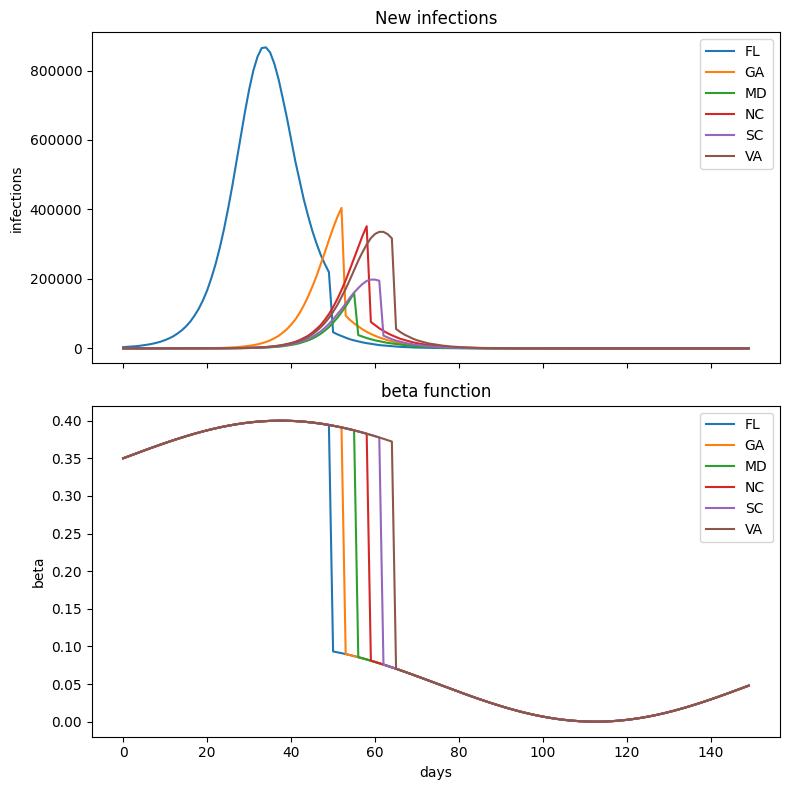

In [6]:
sim = with_fancy_messaging(Simulation(geo, ipm, mm))

param = {
    # IPM params
    'beta': time_varying_beta,
    'gamma': 1/6,
    'xi': 1/90,

    # MM params
    'theta': 0.1,
    'move_control': 0.9,
}


def init(ctx: SimContext) -> Compartments:
    return single_location(ctx, location=0, seed_size=10_000)


out = sim.run(
    param=param,
    start_date=date(2015, 1, 1),
    duration_days=150,
    initializer=init
)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
x_axis = np.arange(150)
ax1.set(title='New infections', ylabel='infections')
ax1.plot(x_axis, event_y_axis(out, 0), label=geo.labels)
ax1.legend()
ax2.set(title='beta function', ylabel='beta', xlabel='days')
ax2.plot(x_axis, time_varying_beta, label=geo.labels)
ax2.legend()
fig.tight_layout()
plt.show()
